In [ ]:
from google.colab import files

In [ ]:
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
import os

In [ ]:
!kaggle datasets download paultimothymooney/chest-xray-pneumonia

 99% 2.28G/2.29G [00:13<00:00, 251MB/s]
100% 2.29G/2.29G [00:13<00:00, 177MB/s]


In [ ]:
import zipfile
with zipfile.ZipFile('chest-xray-pneumonia.zip', 'r') as zf:
  zf.extractall()

img_dir = os.path.join(os.getcwd(), 'chest_xray')
test_img_dir = os.path.join(img_dir, 'test')
train_img_dir = os.path.join(img_dir, 'train')
val_img_dir = os.path.join(img_dir, 'val')

In [ ]:
import tensorflow as tf 
from tensorflow import keras 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, MaxPooling2D, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.applications import ResNet50
from sklearn.metrics import precision_recall_curve, roc_curve, accuracy_score, confusion_matrix, precision_score, recall_score
from sklearn.decomposition import PCA
import PIL.Image
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt 
import seaborn as sns 
plt.style.use('fivethirtyeight')
import pickle 
import os 
import numpy as np
import cv2 
%matplotlib inline
from tqdm import tqdm
import warnings
import pandas as pd
warnings.filterwarnings("ignore")

from sklearn.utils import shuffle

In [ ]:
uploaded = files.upload()
train_df = pd.read_csv('./Chest_xray_Metadata.csv')
train_df.shape
train_df.head(5)

Saving Chest_xray_Metadata.csv to Chest_xray_Metadata.csv


,Unnamed: 0,X_ray_image_name,Label,Dataset_type,Label_2_Virus_category,Label_1_Virus_category
0,0.0,NORMAL/NORMAL2-IM-1128-0001-0001.jpeg,Normal,TRAIN,NaN,NaN
1,1.0,NORMAL/NORMAL2-IM-1141-0001.jpeg,Normal,TRAIN,NaN,NaN
2,2.0,NORMAL/NORMAL2-IM-1422-0001.jpeg,Normal,TRAIN,NaN,NaN
3,3.0,NORMAL/NORMAL2-IM-0886-0001.jpeg,Normal,TRAIN,NaN,NaN
4,4.0,NORMAL/IM-0394-0001.jpeg,Normal,TRAIN,NaN,NaN


In [ ]:
train_df.dropna(how = 'all')
train_df.isnull().sum()

Unnamed: 0                 149
X_ray_image_name             0
Label                        0
Dataset_type                 0
Label_2_Virus_category    5680
Label_1_Virus_category    1674
dtype: int64

In [ ]:
train_df.fillna('unknown', inplace=True)
train_df.isnull().sum()

Unnamed: 0                0
X_ray_image_name          0
Label                     0
Dataset_type              0
Label_2_Virus_category    0
Label_1_Virus_category    0
dtype: int64

In [ ]:
train_data = train_df[train_df['Dataset_type'] == 'TRAIN']
test_data = train_df[train_df['Dataset_type'] == 'TEST']
#assert train_data.shape[0] + test_data.shape[0] == train_df.shape[0]
print(f"Shape of train data : {train_data.shape}")
print(f"Shape of test data : {test_data.shape}")
test_data.sample(10)

Shape of train data : (5216, 6)
Shape of test data : (624, 6)


,Unnamed: 0,X_ray_image_name,Label,Dataset_type,Label_2_Virus_category,Label_1_Virus_category
5537,5630.0,PNEUMONIA/person134_bacteria_644.jpeg,Pnemonia,TEST,unknown,bacteria
5468,5561.0,PNEUMONIA/person157_bacteria_740.jpeg,Pnemonia,TEST,unknown,Virus
5543,5636.0,PNEUMONIA/person100_bacteria_480.jpeg,Pnemonia,TEST,unknown,bacteria
5797,unknown,PNEUMONIA/person19_virus_50.jpeg,Pnemonia,TEST,unknown,unknown
5488,5581.0,PNEUMONIA/person28_virus_62.jpeg,Pnemonia,TEST,unknown,bacteria
5243,5336.0,NORMAL/IM-0046-0001.jpeg,Normal,TEST,unknown,unknown
5490,5583.0,PNEUMONIA/person1_virus_13.jpeg,Pnemonia,TEST,unknown,bacteria
5839,unknown,PNEUMONIA/person121_bacteria_580.jpeg,Pnemonia,TEST,unknown,unknown
5803,unknown,PNEUMONIA/person1637_virus_2834.jpeg,Pnemonia,TEST,unknown,unknown
5605,5698.0,PNEUMONIA/person147_bacteria_711.jpeg,Pnemonia,TEST,unknown,bacteria


In [ ]:
test_img_dir = './chest_xray/test/'
train_img_dir = './chest_xray/train/'

sample_train_images = list(os.walk(train_img_dir))[0][2][:8]
sample_train_images = list(map(lambda x: os.path.join(train_img_dir, x), sample_train_images))
sample_test_images = list(os.walk(test_img_dir))[0][2][:8]
sample_test_images = list(map(lambda x: os.path.join(test_img_dir, x), sample_test_images))

In [ ]:
plt.figure(figsize = (10,10))
for iterator, filename in enumerate(sample_train_images):
    image = plt.imread(filename)
    plt.subplot(4,2,iterator+1)
    plt.axis("off")
    plt.imshow(image, cmap=plt.cm.bone)

plt.tight_layout()

<Figure size 720x720 with 0 Axes>

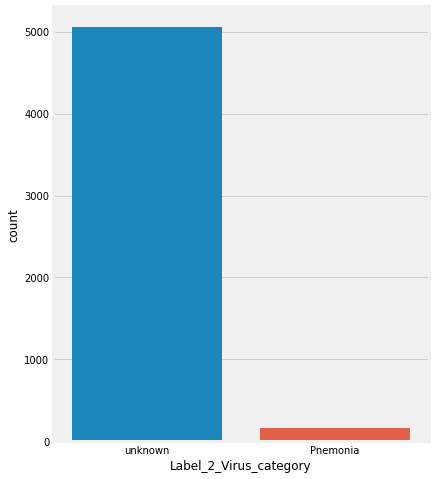

In [ ]:
plt.figure(figsize=(6,8))
sns.countplot(train_data['Label_2_Virus_category']);

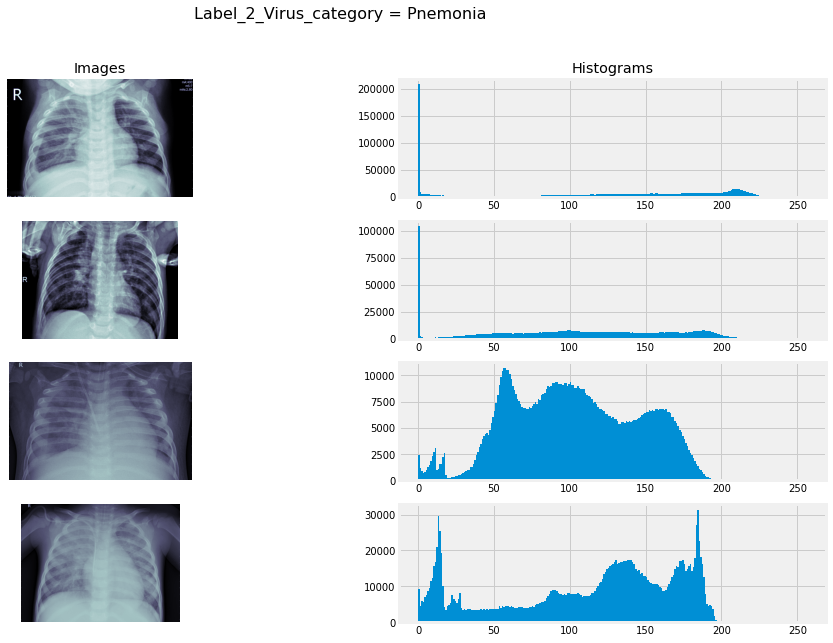

In [ ]:
fig, ax = plt.subplots(4, 2, figsize=(15, 10))


pnemonia_path = train_data[train_data['Label_2_Virus_category']=='Pnemonia']['X_ray_image_name'].values

sample_pnemonia_path = pnemonia_path[6:10]
sample_pnemonia_path = list(map(lambda x: os.path.join(train_img_dir, x), sample_pnemonia_path))

for row, file in enumerate(sample_pnemonia_path):
    image = plt.imread(file)
    ax[row, 0].imshow(image, cmap=plt.cm.bone)
    ax[row, 1].hist(image.ravel(), 256, [0,256])
    ax[row, 0].axis('off')
    if row == 0:
        ax[row, 0].set_title('Images')
        ax[row, 1].set_title('Histograms')
fig.suptitle('Label_2_Virus_category = Pnemonia', size=16)
plt.show()

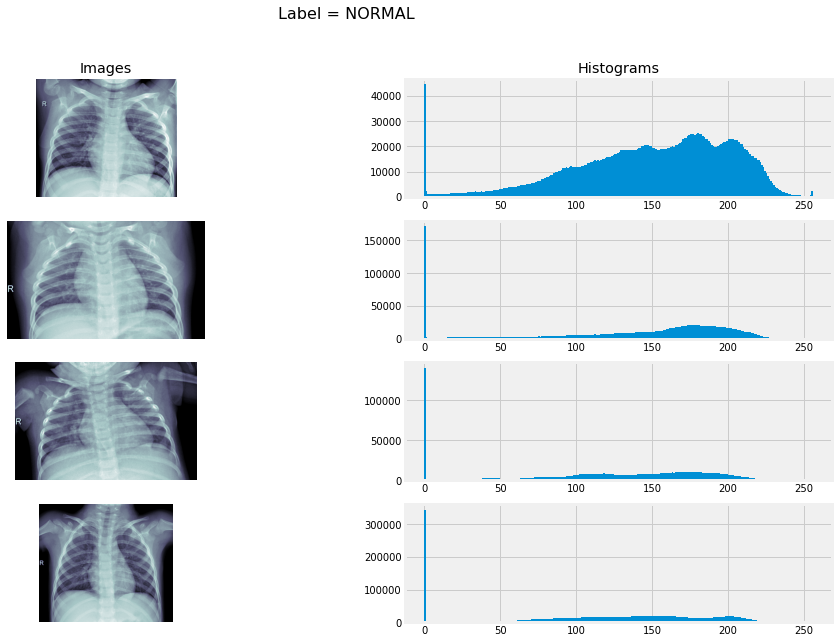

In [ ]:
fig, ax = plt.subplots(4, 2, figsize=(15, 10))


normal_path = train_data[train_data['Label']=='Normal']['X_ray_image_name'].values

sample_normal_path = normal_path[:4]
sample_normal_path = list(map(lambda x: os.path.join(train_img_dir, x), sample_normal_path))

for row, file in enumerate(sample_normal_path):
    image = plt.imread(file)
    ax[row, 0].imshow(image, cmap=plt.cm.bone)
    ax[row, 1].hist(image.ravel(), 256, [0,256])
    ax[row, 0].axis('off')
    if row == 0:
        ax[row, 0].set_title('Images')
        ax[row, 1].set_title('Histograms')
fig.suptitle('Label = NORMAL', size=16)
plt.show()

In [ ]:
final_train_data = train_data[(train_data['Label'] == 'Normal') | 
                              ((train_data['Label'] == 'Pnemonia') &
                               (train_data['Label_2_Virus_category'] == 'Pnemonia'))]

In [ ]:
final_train_data['class'] = final_train_data.Label.apply(lambda x: 'negative' if x=='Normal' else 'positive')
test_data['class'] = test_data.Label.apply(lambda x: 'negative' if x=='Normal' else 'positive')

final_train_data['target'] = final_train_data.Label.apply(lambda x: 0 if x=='Normal' else 1)
test_data['target'] = test_data.Label.apply(lambda x: 0 if x=='Normal' else 1)

In [ ]:
final_train_data = final_train_data[['X_ray_image_name', 'class', 'target', 'Label_2_Virus_category']]
final_test_data = test_data[['X_ray_image_name', 'class', 'target']]

In [ ]:
test_data['Label'].value_counts()

Pnemonia    390
Normal      234
Name: Label, dtype: int64

In [ ]:
datagen =  ImageDataGenerator(
  shear_range=0.2,
  zoom_range=0.2,
)

def read_img(filename, size, path):
    #img = image.load_img(os.path.join(path, filename), target_size=size
    img = tf.keras.preprocessing.image.load_img(os.path.join(path, filename), target_size=size)
    #convert image to array
    input_arr = img_to_array(tf.keras.preprocessing.image.load_img(os.path.join(path, filename), target_size=size)) / 255
    #input_arr = tf.keras.preprocessing.image.img_to_array(image)
    input_arr = np.array(input_arr)
    return input_arr

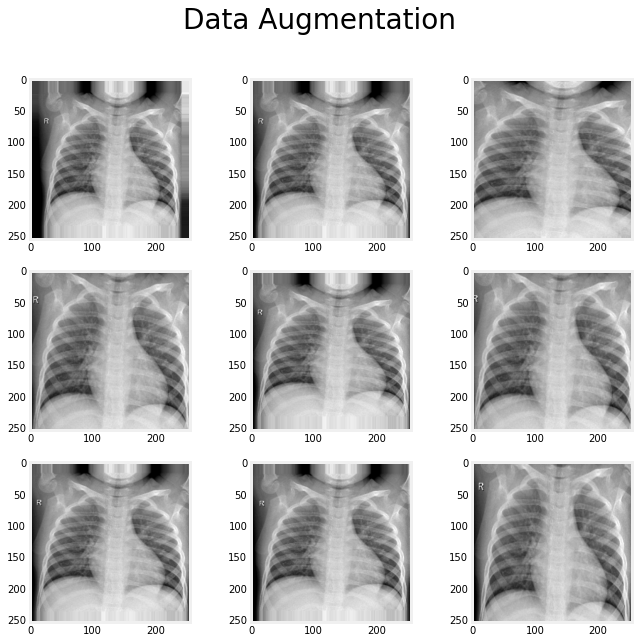

In [ ]:
samp_img = read_img(final_train_data['X_ray_image_name'][0],
                                 (255,255),
                                 train_img_dir)

plt.figure(figsize=(10,10))
plt.suptitle('Data Augmentation', fontsize=28)

i = 0


for batch in datagen.flow(tf.expand_dims(samp_img,0), batch_size=16):
    plt.subplot(3, 3, i+1)
    plt.grid(False)
#     print(batch.shape)
#     print(batch.ndim)
    plt.imshow(batch.reshape(255, 255, 3));
    
    if i == 8:
        break
    i += 1
    
plt.show();

In [ ]:
pnemonia_df = final_train_data[final_train_data['Label_2_Virus_category'] == 'Pnemonia']
with_pnemonia_augmented = []

def augment(name):
    img = read_img(name, (64,64), train_img_dir)
    i = 0
    for batch in tqdm(datagen.flow(tf.expand_dims(img, 0), batch_size=32)):
        with_pnemonia_augmented.append(tf.squeeze(batch).numpy())
        if i == 20:
            break
        i =i+1


pnemonia_df['X_ray_image_name'].apply(augment)

20it [00:00, 611.60it/s]             
20it [00:00, 600.88it/s]             
20it [00:00, 606.78it/s]             
20it [00:00, 665.92it/s]             
20it [00:00, 534.07it/s]             
20it [00:00, 635.13it/s]             
20it [00:00, 644.74it/s]             
20it [00:00, 699.24it/s]             
20it [00:00, 697.51it/s]             
20it [00:00, 710.24it/s]             
20it [00:00, 767.18it/s]             
20it [00:00, 747.21it/s]             
20it [00:00, 703.27it/s]             
20it [00:00, 740.77it/s]             
20it [00:00, 685.04it/s]             
20it [00:00, 677.39it/s]             
20it [00:00, 760.00it/s]             
20it [00:00, 717.70it/s]             
20it [00:00, 688.63it/s]             
20it [00:00, 656.45it/s]             
20it [00:00, 525.83it/s]             
20it [00:00, 740.13it/s]             
20it [00:00, 702.71it/s]             
20it [00:00, 820.67it/s]             
20it [00:00, 701.05it/s]             
20it [00:00, 657.48it/s]             
20it [00:00,

5056    None
5057    None
5058    None
5059    None
5060    None
        ... 
5211    None
5212    None
5213    None
5214    None
5215    None
Name: X_ray_image_name, Length: 160, dtype: object

In [ ]:
train_arrays = []
final_train_data['X_ray_image_name'].apply(lambda x: train_arrays.append(read_img(x, (64,64), train_img_dir)))
test_arrays = []
final_test_data['X_ray_image_name'].apply(lambda x: test_arrays.append(read_img(x, (64,64), test_img_dir)))

5216    None
5217    None
5218    None
5219    None
5220    None
        ... 
5835    None
5836    None
5837    None
5838    None
5839    None
Name: X_ray_image_name, Length: 624, dtype: object

In [ ]:
print(len(train_arrays))
print(len(test_arrays))

1501
624


In [ ]:
y_train = np.concatenate((np.int64(final_train_data['target'].values), np.ones(len(with_pnemonia_augmented), dtype=np.int64)))

In [ ]:
train_arrays.extend(with_pnemonia_augmented)

In [ ]:
train_tensors = tf.convert_to_tensor(np.array(train_arrays))
test_tensors  = tf.convert_to_tensor(np.array(test_arrays))
y_train_tensor = tf.convert_to_tensor(y_train)
y_test_tensor = tf.convert_to_tensor(final_test_data['target'].values)

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_tensors, y_train_tensor))
test_dataset = tf.data.Dataset.from_tensor_slices((test_tensors, y_test_tensor))

tf.Tensor(0, shape=(), dtype=int64)


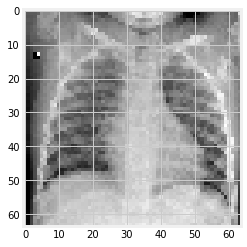

In [ ]:
for i,l in train_dataset.take(1):
    plt.imshow(i);
    print(l)

In [ ]:
BATCH_SIZE = 32
BUFFER = 5000
#BUFFER = int(1e4)
#BATCH_SIZE = 500

train_batches = train_dataset.shuffle(BUFFER).batch(BATCH_SIZE)
test_batches = test_dataset.batch(BATCH_SIZE)

for i,l in train_batches.take(1):
    print('Train Shape per Batch: ',i.shape);
for i,l in test_batches.take(1):
    print('Test Shape per Batch: ',i.shape);

Train Shape per Batch:  (32, 64, 64, 3)
Test Shape per Batch:  (32, 64, 64, 3)


In [ ]:
INPUT_SHAPE = (64,64,3) 

base_model = tf.keras.applications.ResNet50(input_shape= INPUT_SHAPE,
                                               include_top=False,
                                               weights='imagenet')


94781440/94765736 [==============================] - 1s 0us/step


In [ ]:
for i,l in train_batches.take(1):
    pass
base_model(i).shape

TensorShape([32, 2, 2, 2048])

In [ ]:
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(128))
#model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation = 'sigmoid'))

early_stop = EarlyStopping(patience=3, monitor='val_loss', restore_best_weights=True)
adam = Adam(learning_rate=0.0001)
model.compile(loss='binary_crossentropy',optimizer=adam,metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2, 2, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 23,850,113
Trainable params: 23,796,993
Non-trainable params: 53,120
_______________________________________

In [ ]:
history = model.fit(train_batches, epochs=10, validation_data=test_batches)

Epoch 1/10
163/163 [==============================] - 912s 6s/step - loss: 0.2226 - accuracy: 0.9153 - val_loss: 41.3507 - val_accuracy: 0.6250
Epoch 2/10
163/163 [==============================] - 894s 5s/step - loss: 0.1410 - accuracy: 0.9502 - val_loss: 218.5108 - val_accuracy: 0.6250
Epoch 3/10
163/163 [==============================] - 894s 5s/step - loss: 0.1069 - accuracy: 0.9601 - val_loss: 173.8467 - val_accuracy: 0.6250
Epoch 4/10
163/163 [==============================] - 888s 5s/step - loss: 0.0896 - accuracy: 0.9630 - val_loss: 2.4085 - val_accuracy: 0.6266
Epoch 5/10
163/163 [==============================] - 885s 5s/step - loss: 0.0813 - accuracy: 0.9707 - val_loss: 1.5981 - val_accuracy: 0.6250
Epoch 6/10
163/163 [==============================] - 890s 5s/step - loss: 0.0576 - accuracy: 0.9774 - val_loss: 0.9233 - val_accuracy: 0.6699
Epoch 7/10
163/163 [==============================] - 873s 5s/step - loss: 0.0623 - accuracy: 0.9745 - val_loss: 0.8195 - val_accuracy: 0

In [ ]:
history = model.fit(train_batches, epochs=2, validation_data=test_batches)

Epoch 1/2
163/163 [==============================] - 914s 6s/step - loss: 0.0515 - accuracy: 0.9818 - val_loss: 1.1327 - val_accuracy: 0.8253
Epoch 2/2
163/163 [==============================] - 902s 6s/step - loss: 0.0448 - accuracy: 0.9843 - val_loss: 0.3412 - val_accuracy: 0.9199


In [ ]:
#predictions = model.predict(np.array(test_arrays))
pred =(model.predict(np.array(test_arrays)) > 0.5).astype("int32")

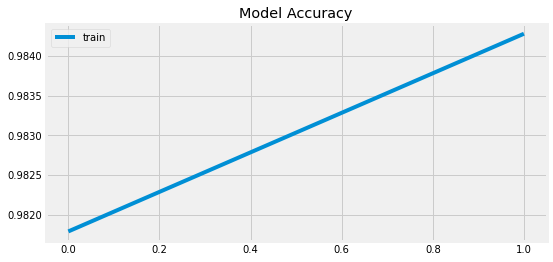

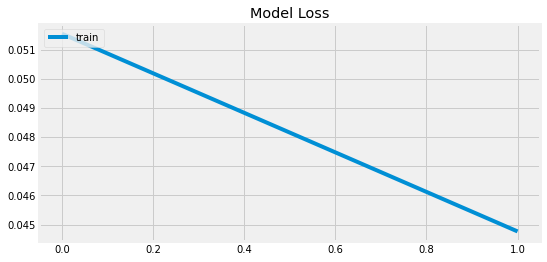

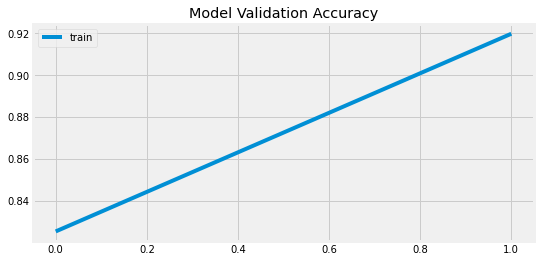

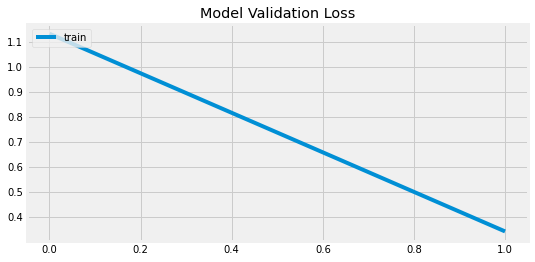

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(history.epoch, history.history['accuracy'])
plt.title('Model Accuracy')
plt.legend(['train'], loc='upper left')
plt.show()

plt.figure(figsize=(8, 4))
plt.plot(history.epoch, history.history['loss'])
plt.title('Model Loss')
plt.legend(['train'], loc='upper left')
plt.show()

plt.figure(figsize=(8, 4))
plt.plot(history.epoch, history.history['val_accuracy'])
plt.title('Model Validation Accuracy')
plt.legend(['train'], loc='upper left')
plt.show()

plt.figure(figsize=(8,4))
plt.plot(history.epoch, history.history['val_loss'])
plt.title('Model Validation Loss')
plt.legend(['train'], loc='upper left')
plt.show()

In [ ]:
# classification report
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(test_data['target'], pred.flatten()))

              precision    recall  f1-score   support

           0       0.98      0.80      0.88       234
           1       0.89      0.99      0.94       390

    accuracy                           0.92       624
   macro avg       0.94      0.90      0.91       624
weighted avg       0.93      0.92      0.92       624



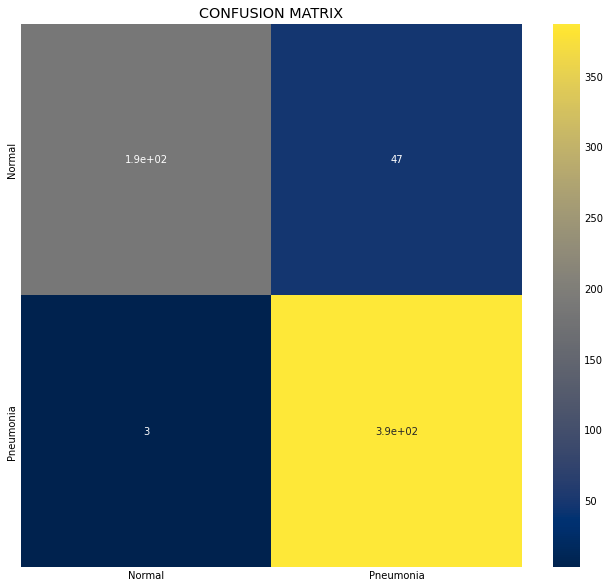

In [ ]:
con_mat = confusion_matrix(test_data['target'], pred.flatten())
plt.figure(figsize = (10,10))
plt.title('CONFUSION MATRIX')
sns.heatmap(con_mat, cmap='cividis',
            yticklabels=['Normal', 'Pneumonia'],
            xticklabels=['Normal', 'Pneumonia'],
            annot=True);

Saving person100_bacteria_475.jpeg to person100_bacteria_475 (1).jpeg
Pneumonia


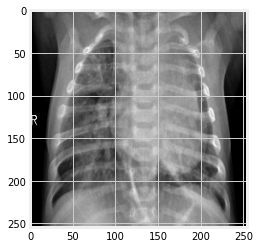

In [ ]:
img_dims = 64
from keras.preprocessing import image
from google.colab import files
uploaded = files.upload()
for image in uploaded.keys():
  path = "/content/"+image
  img = plt.imread(path)
  img = cv2.resize(img, (img_dims, img_dims))
  img = np.dstack([img, img, img])
  img = img.astype('float32') / 255
  result = model.predict(np.expand_dims(img_to_array(img), axis = 0))  

  if result[0][0] > 0.5:
    prediction = 'Pnuemonia'
  else:
    prediction = 'Normal'
    
  print(prediction)
  plt.imshow(img)